# Defensive Stock Analysis

### Overview

Do defensive stocks protect against market volatility? If so should you buy or sell the top 3 market weighted defensive stocks. This analysis is for educational purposes only and does not represent any investment recommendations. 

### Business Problem

During times of uncertainty investors want to protect their assets from loss. For this project we will analyze 3 consumer defensive stocks by performing time series analysis (SARIMA models) and linear regression. By doing so we will try to forecast stock prices in the near future. We will choose the 3 stocks based on highest market caps.

### Data 

The data acquired for this project represents broad market data including, S&P 500, stocks within the S&P500, Etherum, PPI (producer price index), Dollar index, and gold rates. 

The final merged dataset (df4) has 190 columns and contains 8 columns:
<br />Date: Date of close
<br />Symbol: Symbol of defensive stock
<br />Close: Close price of defensive stock
<br />SPClose: Close Price of S&P 500
<br />Gold: Gold Price
<br />Ether: Ethereum Price
<br />USD: US dollar index
<br />PPI: Producer Price Index

### Import Data and packages

Import packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import time
import warnings
import scipy.stats as stats
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit 
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
warnings.simplefilter('ignore', ConvergenceWarning)
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# with zipfile.ZipFile("Data/archive.zip") as zip_ref:
#     zip_ref.extractall("Data")

In [3]:
df1 = pd.read_csv('Data/sp500_companies.csv')
df2 = pd.read_csv('Data/sp500_index.csv')
df3 = pd.read_csv('Data/sp500_stocks.csv')
dfg = pd.read_csv('Data/daily_gold_rate.csv')
deth = pd.read_csv('Data/CBETHUSD.csv')
dollar = pd.read_csv('Data/DTWEXBGS.csv')
ppi = pd.read_csv('Data/WPU02850113.csv')

## Datasets 

### Dataset #1

This dataset represents information regarding all stocks within the S&P500. We will narrow this stock down to only consumer defensive stocks, and choose the stocks we will be using for analysis based on market cap. 

In [4]:
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,149.70,2381442449408,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.067072
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,247.11,1855296897024,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.052254
2,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.41,1249782136832,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.73,1249780563968,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
4,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,100.79,1028229365760,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,"Amazon.com, Inc. engages in the retail sale of...",0.028960


In [5]:
df1 = df1[df1['Sector'] == 'Consumer Defensive']
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
11,NYQ,WMT,Walmart Inc.,Walmart Inc.,Consumer Defensive,Discount Stores,142.58,395499831296,3.458600e+10,0.084,Bentonville,AR,United States,2300000.0,Walmart Inc. engages in the operation of retai...,0.011139
13,NYQ,PG,Procter & Gamble Company (The),The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,140.97,341140373504,2.136400e+10,0.013,Cincinnati,OH,United States,106000.0,The Procter & Gamble Company provides branded ...,0.009608
20,NYQ,KO,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,61.32,264866824192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,"The Coca-Cola Company, a beverage company, man...",0.007460
22,NMS,PEP,"Pepsico, Inc.","PepsiCo, Inc.",Consumer Defensive,Beverages—Non-Alcoholic,178.05,246180839424,1.515600e+10,0.088,Purchase,NY,United States,309000.0,"PepsiCo, Inc. manufactures, markets, distribut...",0.006934
23,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,515.47,228575887360,9.693000e+09,0.150,Issaquah,WA,United States,304000.0,"Costco Wholesale Corporation, together with it...",0.006438


### Dataset #2

This dataset contains close price of the S&P500 and the date of close. We will convert the values in the "Date" column to datetime. 

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2519 non-null   object 
 1   S&P500  2519 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [7]:
df2.head()

,Date,S&P500
0,2012-11-12,1380.03
1,2012-11-13,1374.53
2,2012-11-14,1355.49
3,2012-11-15,1353.33
4,2012-11-16,1359.88


In [8]:
df2.shape

(2519, 2)

In [9]:
df2['Date'] = pd.to_datetime(df2['Date'],infer_datetime_format=True)

In [10]:
# df2=df2[df2['Date'] >= '2019-01-1']

In [11]:
df2 = df2.rename(columns={"S&P500":"SPClose"})

In [12]:
df2['Symbol'] = "S&P500"

In [13]:
df2.head()

,Date,SPClose,Symbol
0,2012-11-12,1380.03,S&P500
1,2012-11-13,1374.53,S&P500
2,2012-11-14,1355.49,S&P500
3,2012-11-15,1353.33,S&P500
4,2012-11-16,1359.88,S&P500


In [14]:
df2.isna().sum()

Date       0
SPClose    0
Symbol     0
dtype: int64

### Dataset #3

This dataset contains all stocks within the S&P500, the symbol, adj close, close, high, low, open, and volume. We will only be using the date, symbol, and close columns and only be using 'PEP', 'KO', 'PG', 'WMT', 'COST' symbols. We will also convert the date column to datetime. 

In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629217 entries, 0 to 1629216
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1629217 non-null  object 
 1   Symbol     1629217 non-null  object 
 2   Adj Close  1560290 non-null  float64
 3   Close      1560290 non-null  float64
 4   High       1560290 non-null  float64
 5   Low        1560290 non-null  float64
 6   Open       1560290 non-null  float64
 7   Volume     1560290 non-null  float64
dtypes: float64(6), object(2)
memory usage: 99.4+ MB


In [16]:
df3['Date'] = pd.to_datetime(df3['Date'])

In [17]:
df3 = df3.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1)

In [18]:
df3.head()

,Date,Symbol,Close
0,2010-01-04,MMM,83.019997
1,2010-01-05,MMM,82.500000
2,2010-01-06,MMM,83.669998
3,2010-01-07,MMM,83.730003
4,2010-01-08,MMM,84.320000


In [19]:
df3 = df3.loc[df3['Symbol'].isin(['PEP', 'KO', 'PG', 'WMT', 'COST'])]

In [20]:
df3.isna().sum()

Date      0
Symbol    0
Close     0
dtype: int64

In [21]:
df3['Date'] = pd.to_datetime(df3['Date'],infer_datetime_format=True)

In [22]:
# df3=df3[df3['Date'] >= '2019-01-1']

In [23]:
df3.head()

,Date,Symbol,Close
382202,2010-01-04,KO,28.520000
382203,2010-01-05,KO,28.174999
382204,2010-01-06,KO,28.165001
382205,2010-01-07,KO,28.094999
382206,2010-01-08,KO,27.575001


### Dfg 

Dfg represents the daily gold rate. We will only keep the gold rate that is relevant to the US dollar, and we will convert the date column to datetime. 

In [24]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9824 non-null   object 
 1   USD     9824 non-null   float64
 2   EUR     9824 non-null   float64
 3   GBP     9824 non-null   float64
 4   INR     9824 non-null   float64
 5   AED     9824 non-null   float64
 6   CNY     9820 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.4+ KB


In [25]:
dfg = dfg.drop(['EUR','GBP','INR','AED','CNY'],axis=1)

In [26]:
dfg = dfg.rename(columns={"USD":"Gold"})

In [27]:
dfg.isna().sum()

Date    0
Gold    0
dtype: int64

In [28]:
dfg['Date'] = pd.to_datetime(dfg['Date'],infer_datetime_format=True)

In [29]:
# dfg=dfg[dfg['Date'] >= '2019-01-1']

In [30]:
dfg.head()

,Date,Gold
0,1985-01-01,308.30
1,1985-01-02,305.50
2,1985-01-03,302.30
3,1985-01-04,303.15
4,1985-01-07,298.25


In [31]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9824 non-null   datetime64[ns]
 1   Gold    9824 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.6 KB


### Deth

Deth is ethereum prices. We will keep the dataset relatively unchanged, and will convert the date column to datetime. 

In [32]:
deth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1827 non-null   object
 1   CBETHUSD  1827 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB


In [33]:
deth.isna().sum()

DATE        0
CBETHUSD    0
dtype: int64

In [34]:
deth = deth.rename(columns={"DATE":"Date","CBETHUSD":"Ether"})

In [35]:
deth['Date'] = pd.to_datetime(deth['Date'],infer_datetime_format=True)

In [36]:
# deth=deth[deth['Date'] >= '2019-01-1']

In [37]:
deth.head()

,Date,Ether
0,2017-11-22,381.73
1,2017-11-23,406.61
2,2017-11-24,470.98
3,2017-11-25,466.77
4,2017-11-26,473.99


### Dollar

This dataset is the US dollar index, we will convert the date column of this dataset to datetime.  

In [38]:
dollar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1305 non-null   object
 1   DTWEXBGS  1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [39]:
dollar.isna().sum()

DATE        0
DTWEXBGS    0
dtype: int64

In [40]:
dollar = dollar.rename(columns={"DATE":"Date", "DTWEXBGS":"USD"})

In [41]:
dollar['Date'] = pd.to_datetime(dollar['Date'],infer_datetime_format=True)

In [42]:
# dollar=dollar[dollar['Date'] >= '2019-01-1']

In [43]:
dollar.head()

,Date,USD
0,2017-11-20,111.261
1,2017-11-21,110.9836
2,2017-11-22,110.5642
3,2017-11-23,.
4,2017-11-24,110.0266


In [44]:
dollar.tail()

,Date,USD
1300,2022-11-14,123.5788
1301,2022-11-15,123.1759
1302,2022-11-16,123.4178
1303,2022-11-17,124.1229
1304,2022-11-18,123.9828


### PPI 

The final dataset is the producer price index for goods, excluding seafood. We will change the "WPU02850113" column to "PPI" and convert the date column to datetime. 

In [45]:
ppi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         479 non-null    object 
 1   WPU02850113  479 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [46]:
ppi.isna().sum()

DATE           0
WPU02850113    0
dtype: int64

In [47]:
ppi = ppi.rename(columns={"DATE":"Date", "WPU02850113":"PPI"})

In [48]:
ppi['Date'] = pd.to_datetime(ppi['Date'],infer_datetime_format=True)

In [49]:
ppi

,Date,PPI
0,1982-12-01,100.000
1,1983-01-01,99.700
2,1983-02-01,100.400
3,1983-03-01,101.500
4,1983-04-01,102.200
...,...,...
474,2022-06-01,269.192
475,2022-07-01,269.265
476,2022-08-01,269.651
477,2022-09-01,276.928


In [50]:
ppi['Date'] = pd.to_datetime(ppi.Date, format='%d/%m/%Y')
ppi.set_index('Date').resample('D').ffill()

,PPI
Date,
1982-12-01,100.000
1982-12-02,100.000
1982-12-03,100.000
1982-12-04,100.000
1982-12-05,100.000
...,...
2022-09-27,276.928
2022-09-28,276.928
2022-09-29,276.928


In [51]:
# ppi=ppi[ppi['Date'] >= '2019-01-1']

In [52]:
ppi.head()

,Date,PPI
0,1982-12-01,100.0
1,1983-01-01,99.7
2,1983-02-01,100.4
3,1983-03-01,101.5
4,1983-04-01,102.2


## Merge datasets

Below we will merge all datasets above, excluding df1, together. 

In [53]:
df4 = pd.merge(df2,df3, on='Date', how='outer')

In [54]:
df4 = pd.merge(df4, dfg, on='Date')

In [55]:
df4 = pd.merge(df4, deth, on='Date')

In [56]:
df4 = pd.merge(df4, dollar, on='Date')

In [57]:
df4 = pd.merge(df4, ppi, on='Date')

In [58]:
df4.drop('Symbol_x', axis=1)

,Date,SPClose,Symbol_y,Close,Gold,Ether,USD,PPI
0,2017-12-01,2642.22,KO,45.970001,1275.5,463.82,110.1432,186.000
1,2017-12-01,2642.22,COST,185.130005,1275.5,463.82,110.1432,186.000
2,2017-12-01,2642.22,PEP,116.779999,1275.5,463.82,110.1432,186.000
3,2017-12-01,2642.22,PG,90.360001,1275.5,463.82,110.1432,186.000
4,2017-12-01,2642.22,WMT,97.349998,1275.5,463.82,110.1432,186.000
...,...,...,...,...,...,...,...,...
185,2022-08-01,4118.63,KO,64.519997,1772.4,1629.76,121.5001,269.651
186,2022-08-01,4118.63,COST,546.809998,1772.4,1629.76,121.5001,269.651
187,2022-08-01,4118.63,PEP,176.949997,1772.4,1629.76,121.5001,269.651
188,2022-08-01,4118.63,PG,142.899994,1772.4,1629.76,121.5001,269.651


In [59]:
df4 = df4.rename(columns={'Symbol_y': 'Symbol'})

In [60]:
df4 = df4[['Date', 'Symbol', 'Close', 'SPClose','Gold','Ether','USD','PPI']]

In [61]:
df4.head(20)

,Date,Symbol,Close,SPClose,Gold,Ether,USD,PPI
0,2017-12-01,KO,45.970001,2642.22,1275.50,463.82,110.1432,186.0
1,2017-12-01,COST,185.130005,2642.22,1275.50,463.82,110.1432,186.0
2,2017-12-01,PEP,116.779999,2642.22,1275.50,463.82,110.1432,186.0
3,2017-12-01,PG,90.360001,2642.22,1275.50,463.82,110.1432,186.0
4,2017-12-01,WMT,97.349998,2642.22,1275.50,463.82,110.1432,186.0
5,2018-02-01,KO,47.450001,2821.98,1341.35,1017.48,106.4903,186.2
6,2018-02-01,COST,193.470001,2821.98,1341.35,1017.48,106.4903,186.2
7,2018-02-01,PEP,120.300003,2821.98,1341.35,1017.48,106.4903,186.2
8,2018-02-01,PG,85.849998,2821.98,1341.35,1017.48,106.4903,186.2
9,2018-02-01,WMT,105.519997,2821.98,1341.35,1017.48,106.4903,186.2


In [62]:
df4['USD']=df4['USD'].astype(float)

In [63]:
df4['Ether']=df4['Ether'].astype(float)

In [64]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     190 non-null    datetime64[ns]
 1   Symbol   190 non-null    object        
 2   Close    190 non-null    float64       
 3   SPClose  190 non-null    float64       
 4   Gold     190 non-null    float64       
 5   Ether    190 non-null    float64       
 6   USD      190 non-null    float64       
 7   PPI      190 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.4+ KB


## EDA

Here we begin exploratory data analysis (EDA) before we begin time series modeling. We will explore WMT, KO, and PG by separating those stocks into their own respective groups. 

In [65]:
symbol_groups = df4.groupby(by='Symbol')

In [66]:
COST = symbol_groups.get_group('COST')
WMT = symbol_groups.get_group('WMT')
KO = symbol_groups.get_group('KO')
PG = symbol_groups.get_group('PG')
PEP = symbol_groups.get_group('PEP')

### WMT EDA

Examining the correlation table below we can see that the close price of WMT is nearly 1:1 with Gold.

In [67]:
wmt_corr = WMT.corr()
wmt_corr

,Close,SPClose,Gold,Ether,USD,PPI
Close,1.000000,0.837826,0.932504,0.640993,0.218195,0.469566
SPClose,0.837826,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.932504,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.640993,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.218195,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.469566,0.657400,0.568375,0.498839,0.334263,1.000000


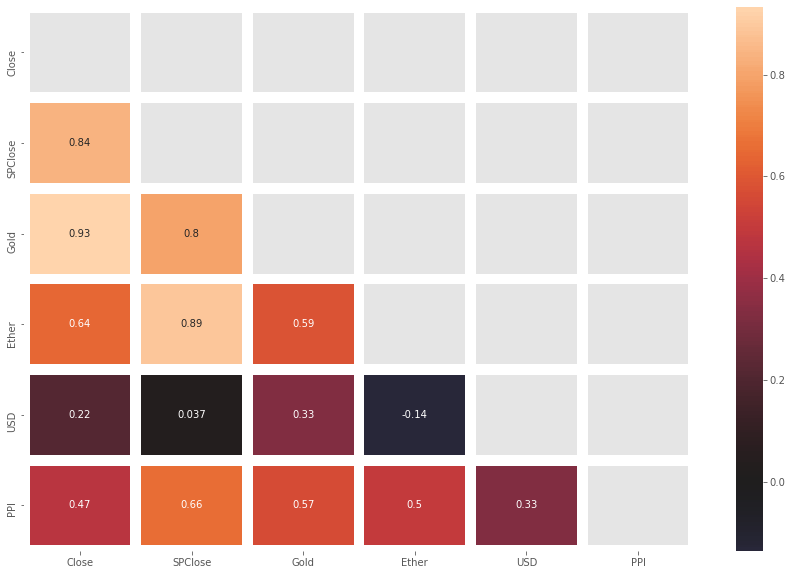

In [68]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(WMT.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(wmt_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

Text(0.5, 1.0, 'Time Series WMT')

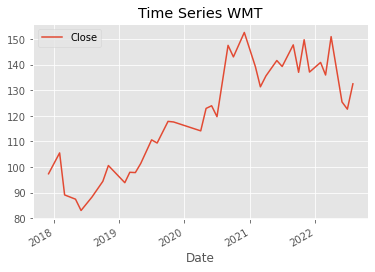

In [69]:
WMT.plot(x='Date',y='Close')
plt.title("Time Series WMT")

Above we can see what was expected with the close price of WMT, we can see the major dip that WMT experienced at the beginning of the pandemic when the market was struggling.

### KO EDA 

Below we can see that the close price of KO is most correlated with the close price of the S&P500. 

In [70]:
ko_corr = KO.corr()
ko_corr

,Close,SPClose,Gold,Ether,USD,PPI
Close,1.000000,0.771784,0.601263,0.585042,0.256273,0.857674
SPClose,0.771784,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.601263,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.585042,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.256273,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.857674,0.657400,0.568375,0.498839,0.334263,1.000000


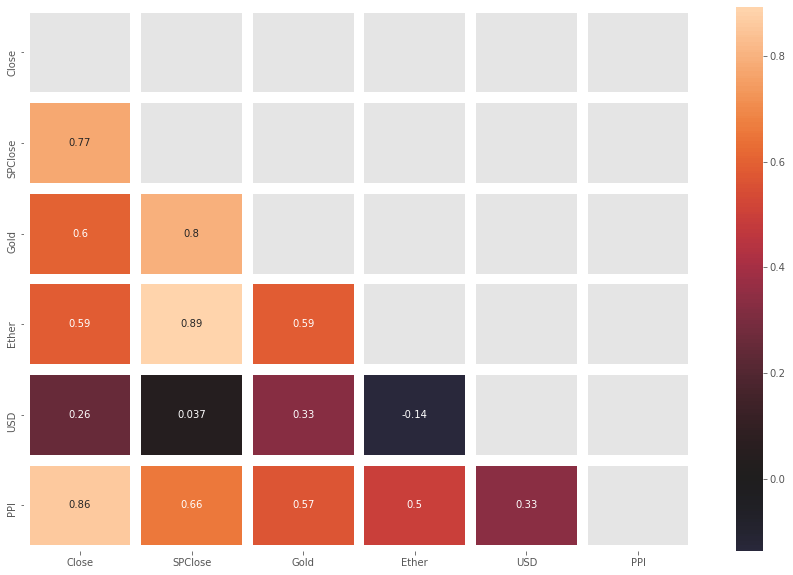

In [71]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(KO.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(ko_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

Text(0.5, 1.0, 'Time Series KO')

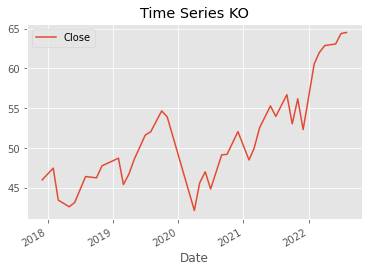

In [72]:
KO.plot(x='Date',y='Close')
plt.title("Time Series KO")

KO didn't experience as much of a drop as WMT did during the pandemic. 

### PG EDA 

Like WMT PG is most correlated with Gold. 

In [73]:
pg_corr = PG.corr()
pg_corr

,Close,SPClose,Gold,Ether,USD,PPI
Close,1.000000,0.859708,0.900333,0.635895,0.394046,0.679719
SPClose,0.859708,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.900333,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.635895,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.394046,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.679719,0.657400,0.568375,0.498839,0.334263,1.000000


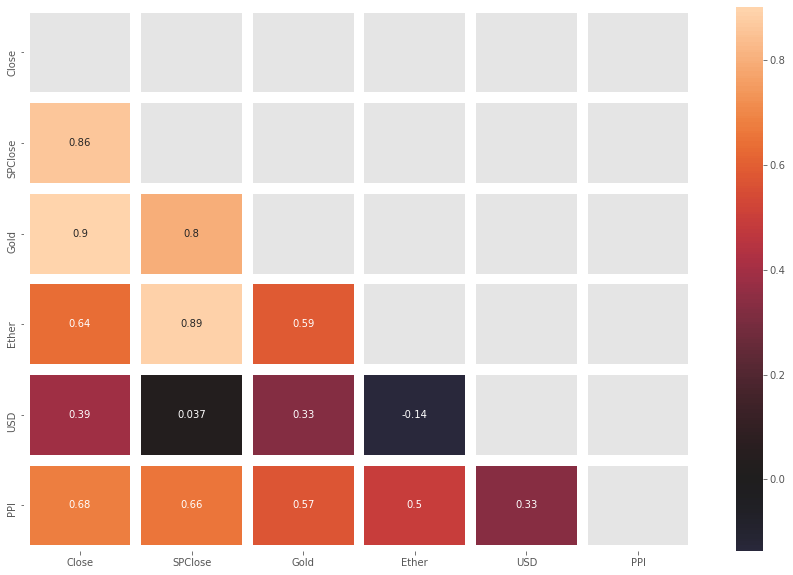

In [74]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(PG.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(pg_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

Text(0.5, 1.0, 'Time Series PG')

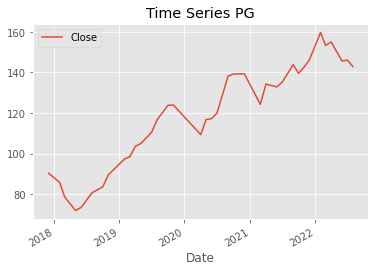

In [75]:
PG.plot(x='Date',y='Close')
plt.title("Time Series PG")

Also like WMT PG experienced a low during the pandemic.

### Preprocessing

We begin preprocessing for time series analysis (SARIMA models). For SARIMA models we will need 3 parameters, p, d, and q which we will define below.

In [76]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Preprocessing WMT

Each stock will need its individual preprocessing, we will begin with WMT. Since we will be only using the date and close we will drop 'SPClose','Gold','PPI','Ether','USD', and 'Symbol' columns.

In [77]:
WMT_new = WMT.drop(['SPClose','Gold','PPI','Ether','USD','Symbol'],axis=1)

In [78]:
WMT_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 4 to 189
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    38 non-null     datetime64[ns]
 1   Close   38 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 912.0 bytes


We want to make sure that the Datetime index is named "date".

In [79]:
# Make sure that index is DatetimeIndex named "date"
if isinstance(WMT.index, pd.DatetimeIndex):
    WMT.index.name = 'Date'
else:
    WMT.rename(columns={'index':'Date'}, inplace=True)
    WMT.set_index('Date', inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


We will set the frequency of the dates to daily, and also fill in missing dates, weekends and holidays, using back fill.

In [80]:
wmt_new = WMT.asfreq('D')

# The 'MS' string groups the data in buckets by start of the month
wmt_new = wmt_new['Close'].resample('MS').mean()

In [81]:
# The term bfill means that we use the value before filling in missing values
wmt_new = wmt_new.fillna(wmt_new.bfill())

In [82]:
wmt_new = wmt_new.resample('D').mean()

In [83]:
wmt_new

Date
2017-12-01     97.349998
2017-12-02           NaN
2017-12-03           NaN
2017-12-04           NaN
2017-12-05           NaN
                 ...    
2022-07-28           NaN
2022-07-29           NaN
2022-07-30           NaN
2022-07-31           NaN
2022-08-01    132.539993
Freq: D, Name: Close, Length: 1705, dtype: float64

In [84]:
wmt_new = wmt_new.fillna(wmt_new.bfill())

wmt_new

Date
2017-12-01     97.349998
2017-12-02    105.519997
2017-12-03    105.519997
2017-12-04    105.519997
2017-12-05    105.519997
                 ...    
2022-07-28    132.539993
2022-07-29    132.539993
2022-07-30    132.539993
2022-07-31    132.539993
2022-08-01    132.539993
Freq: D, Name: Close, Length: 1705, dtype: float64

### SARIMA model WMT

We will start the SARIMA model for WMT. To start we will begin with a gridsearch with the p d and q values defined above. 

In [85]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(wmt_new,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=21210.915808708887
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=18859.374644543866
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=10219.52016660312
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=10161.012830523217
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=10228.71632211432
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=10223.003703850662
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=10166.05837383225
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=10135.357516182994
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=18871.270964451203
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=16566.37278629316
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=8730.676342776545
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=8647.642896036119
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=8746.787665508822
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=8700.067952330639
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=8667.015551001105
ARIM

Now we will plug in the optimal values defined above into the SARIMAX model. 

In [86]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(wmt_new, 
                                        order=(5, 5, 5), 
                                        seasonal_order=(1, 1, 1, 12), 
                                         enforce_stationarity=False, 
                                         enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2101      0.032    -69.497      0.000      -2.272      -2.148
ar.L2         -2.5353      0.048    -52.605      0.000      -2.630      -2.441
ar.L3         -2.1132      0.043    -49.717      0.000      -2.197      -2.030
ar.L4         -1.4520      0.033    -44.580      0.000      -1.516      -1.388
ar.L5         -0.5359      0.016    -34.149      0.000      -0.567      -0.505
ma.L1         -1.3959      0.032    -43.503      0.000      -1.459      -1.333
ma.L2         -0.7112      0.077     -9.211      0.000      -0.863      -0.560
ma.L3          0.9028      0.075     11.988      0.000       0.755       1.050
ma.L4          0.9156      0.068     13.451      0.000       0.782       1.049
ma.L5         -0.7111      0.031    -23.054      0.000      -0.772      -0.651
ar.S.L12      -0.1119      0.045     -2.496      0.0

Below we will plot the diagnostics. 

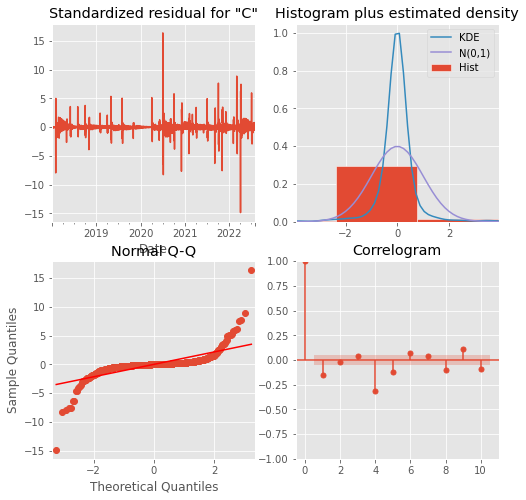

In [87]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(8, 8))
plt.show()

We can see that there is an observable pattern that we will be able to forecast with.  

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

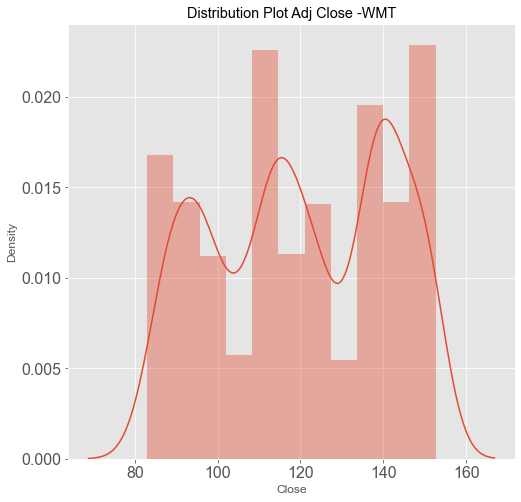

In [88]:
##Checking Distribution of Our Data 
fig = plt.figure(figsize=(8,8))
sns.distplot(wmt_new).set_title("Distribution Plot Adj Close -WMT")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [89]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=False)
pred_conf = pred.conf_int()

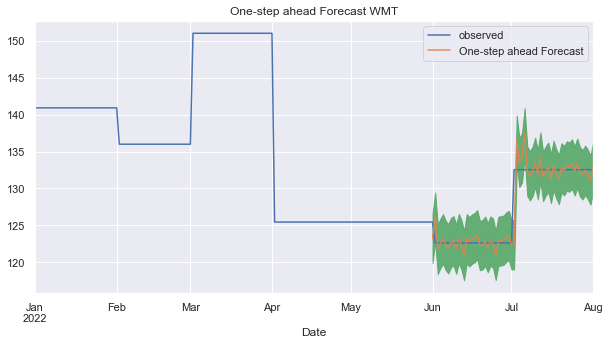

In [90]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = (10, 5)

# Plot observed values
ax = wmt_new['2022':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.9)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.set_title('One-step ahead Forecast WMT')
plt.legend()
plt.show()

In [91]:
pred.predicted_mean

Date
2022-06-01    123.240407
2022-06-02    126.107653
2022-06-03    121.757229
2022-06-04    122.575142
2022-06-05    123.181906
                 ...    
2022-07-28    131.847582
2022-07-29    132.456200
2022-07-30    131.919472
2022-07-31    131.135246
2022-08-01    132.840532
Freq: D, Name: predicted_mean, Length: 62, dtype: float64

In [92]:
# Get the real and predicted values
WMT_forecasted = pred.predicted_mean
WMT_truth = wmt_new['2022-06-01':]

# Compute the mean square error
mse = ((WMT_forecasted - WMT_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.12


In [93]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

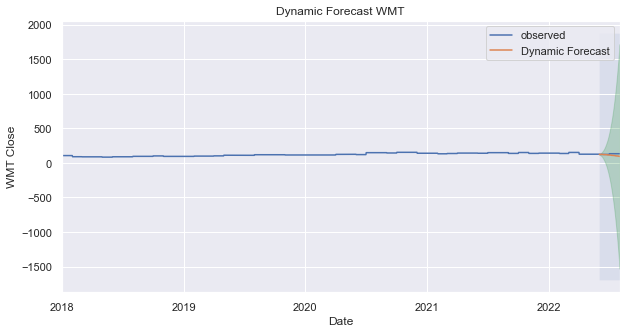

In [94]:
# Plot the dynamic forecast with confidence intervals.

ax = wmt_new['2017-12-31':].plot(label='observed', figsize=(10, 5))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-06-01'), WMT_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('WMT Close')
ax.set_title('Dynamic Forecast WMT')
plt.legend()
plt.show()

After analysis we can see that WMT has acted relatively flat but does show a slight downward trend for the future. For the following two stocks we will follow the same steps as above. 

### Preprocessing KO

In [95]:
# Drop 'SPClose','Gold','PPI','Ether','USD','Symbol' columns
ko_new = KO.drop(['SPClose','Gold','PPI','Ether','USD','Symbol'],axis=1)

In [96]:
# Make sure that index is DatetimeIndex named "date"
if isinstance(ko_new.index, pd.DatetimeIndex):
    ko_new.index.name = 'Date'
else:
    ko_new.rename(columns={'index':'Date'}, inplace=True)
    ko_new.set_index('Date', inplace=True)

In [97]:
ko_new = ko_new.asfreq('D')

# The 'MS' string groups the data in buckets by start of the month
ko_new = ko_new['Close'].resample('MS').mean()

In [98]:
# The term bfill means that we use the value before filling in missing values
ko_new = ko_new.fillna(ko_new.bfill())

In [99]:
# resample the dates 
ko_new = ko_new.resample('D').mean()

In [100]:
# use bfill to fill in any missing date values
ko_new = ko_new.fillna(ko_new.bfill())

ko_new

Date
2017-12-01    45.970001
2017-12-02    47.450001
2017-12-03    47.450001
2017-12-04    47.450001
2017-12-05    47.450001
                ...    
2022-07-28    64.519997
2022-07-29    64.519997
2022-07-30    64.519997
2022-07-31    64.519997
2022-08-01    64.519997
Freq: D, Name: Close, Length: 1705, dtype: float64

### SARIMA model KO 

In [101]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ko_new,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=18250.250664500658
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=15897.422717727426
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=6558.557158837687
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=6526.014099672454
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=6557.47795084707
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=6555.856375496747
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=6528.895952966674
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=6528.014099229133
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=15902.368117094598
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=13602.090587477032
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=5071.5865246833255
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=5024.267738702116
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=5075.49550176012
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=5044.596086639409
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=5032.027804700128
ARIMA (

In [102]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL_KO = sm.tsa.statespace.SARIMAX(ko_new, 
                                        order=(5, 5, 5), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                         enforce_invertibility=False)

# Fit the model and print results
output_ko = ARIMA_MODEL_KO.fit()

print(output_ko.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1305      0.046    -46.671      0.000      -2.220      -2.041
ar.L2         -2.5420      0.077    -32.866      0.000      -2.694      -2.390
ar.L3         -2.0933      0.073    -28.766      0.000      -2.236      -1.951
ar.L4         -1.3130      0.083    -15.877      0.000      -1.475      -1.151
ar.L5         -0.4310      0.042    -10.317      0.000      -0.513      -0.349
ma.L1         -1.5123      0.054    -28.075      0.000      -1.618      -1.407
ma.L2         -0.5450      0.103     -5.277      0.000      -0.747      -0.343
ma.L3          0.8105      0.146      5.561      0.000       0.525       1.096
ma.L4          1.0651      0.137      7.785      0.000       0.797       1.333
ma.L5         -0.8183      0.048    -17.205      0.000      -0.911      -0.725
ar.S.L12       0.1946      0.022      8.955      0.0

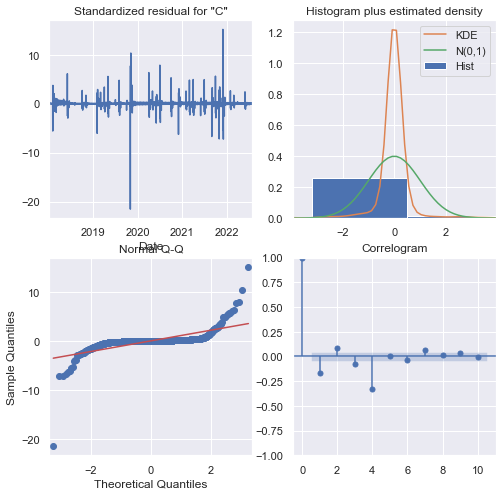

In [103]:
# Call plot_diagnostics() on the results calculated above 
output_ko.plot_diagnostics(figsize=(8, 8))
plt.show()

Follows the same relative trends as WMT. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

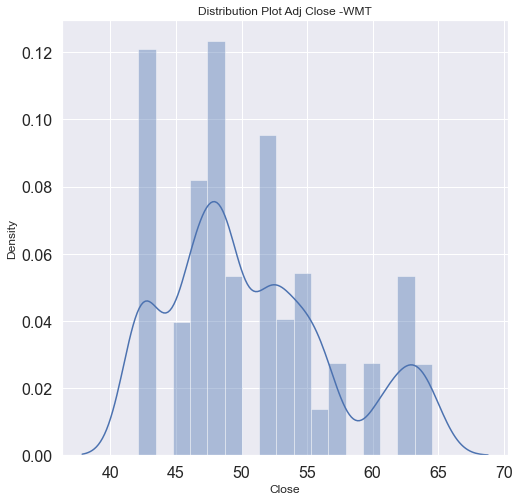

In [104]:
##Checking Distribution of Our Data 
fig = plt.figure(figsize=(8,8))
sns.distplot(ko_new).set_title("Distribution Plot Adj Close -WMT")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [105]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=False)
pred_conf = pred.conf_int()

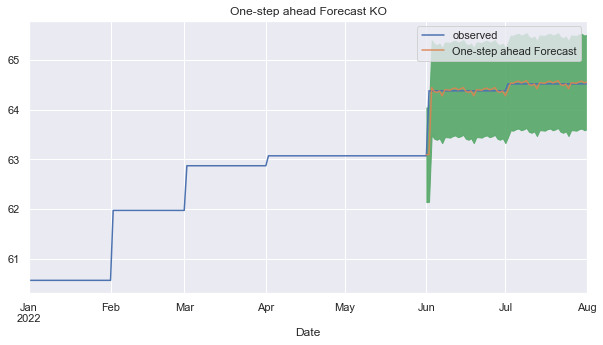

In [106]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = (10, 5)

# Plot observed values
ax = ko_new['2022':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.9)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.set_title('One-step ahead Forecast KO')
plt.legend()

plt.show()

In [107]:
pred.predicted_mean

Date
2022-06-01    63.090767
2022-06-02    63.097319
2022-06-03    64.445358
2022-06-04    64.367432
2022-06-05    64.347710
                ...    
2022-07-28    64.530740
2022-07-29    64.560939
2022-07-30    64.573763
2022-07-31    64.540028
2022-08-01    64.555638
Freq: D, Name: predicted_mean, Length: 62, dtype: float64

In [108]:
# Get the real and predicted values
KO_forecasted = pred.predicted_mean
KO_truth = ko_new['2022-06-01':]

# Compute the mean square error
mse = ((KO_forecasted - KO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.03


In [109]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

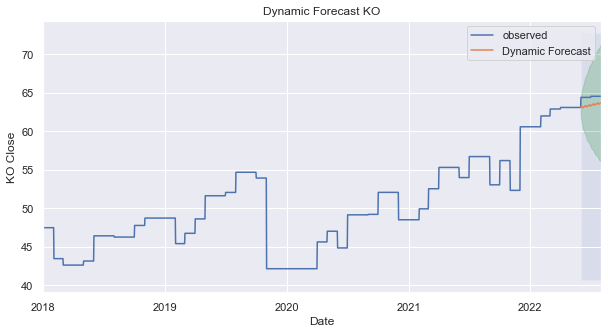

In [110]:
# Plot the dynamic forecast with confidence intervals.

ax = ko_new['2017-12-31':].plot(label='observed', figsize=(10, 5))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-06-01'), KO_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('KO Close')
ax.set_title('Dynamic Forecast KO')
plt.legend()
plt.show()

After analysis we have determined that WMT shows a positive trend. 

### Preprocessing PG 

In [111]:
# drop unnecessary columns
pg_new = PG.drop(['SPClose','Gold','PPI','Ether','USD','Symbol'],axis=1)

In [112]:
# Make sure that index is DatetimeIndex named "date"
if isinstance(pg_new.index, pd.DatetimeIndex):
    pg_new.index.name = 'Date'
else:
    pg_new.rename(columns={'index':'Date'}, inplace=True)
    pg_new.set_index('Date', inplace=True)

In [113]:
pg_new = pg_new.asfreq('D')

# The 'MS' string groups the data in buckets by start of the month
pg_new = pg_new['Close'].resample('MS').mean()

In [114]:
# The term bfill means that we use the value before filling in missing values
pg_new = pg_new.fillna(ko_new.bfill())

In [115]:
pg_new = pg_new.resample('D').mean()

In [116]:
# use bfill to fill in any missing date values
pg_new = pg_new.fillna(ko_new.bfill())

pg_new

Date
2017-12-01     90.360001
2017-12-02     47.450001
2017-12-03     47.450001
2017-12-04     47.450001
2017-12-05     47.450001
                 ...    
2022-07-28     64.519997
2022-07-29     64.519997
2022-07-30     64.519997
2022-07-31     64.519997
2022-08-01    142.899994
Freq: D, Name: Close, Length: 1705, dtype: float64

### SARIMA model PG 

In [117]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(pg_new,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=18417.10184473399
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=16768.071922124178
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=13952.226934271308
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=12941.914580421104
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=13942.059363779012
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=13006.83149948835
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=13416.574662123814
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=12943.913860763045
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=16850.29740430243
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=15909.532726816096
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=13946.755295407924
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=12932.187956270369
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=13942.519601522483
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=12999.182321360364
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=13417.93837245140

In [118]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL_PG = sm.tsa.statespace.SARIMAX(pg_new, 
                                        order=(5, 5, 5), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                         enforce_invertibility=False)

# Fit the model and print results
output_pg = ARIMA_MODEL_PG.fit()

print(output_pg.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4095     12.233     -0.197      0.844     -26.386      21.567
ar.L2         -2.7223     21.430     -0.127      0.899     -44.723      39.279
ar.L3         -1.7931     17.768     -0.101      0.920     -36.617      33.031
ar.L4         -0.7169      8.671     -0.083      0.934     -17.711      16.277
ar.L5         -0.1361      2.127     -0.064      0.949      -4.304       4.032
ma.L1         -1.7667     12.241     -0.144      0.885     -25.759      22.226
ma.L2         -0.1479     30.169     -0.005      0.996     -59.277      58.981
ma.L3          1.1307     20.021      0.056      0.955     -38.110      40.371
ma.L4          0.2764     12.807      0.022      0.983     -24.825      25.378
ma.L5         -0.4924      7.331     -0.067      0.946     -14.862      13.877
ar.S.L12      -0.0820      0.320     -0.256      0.7

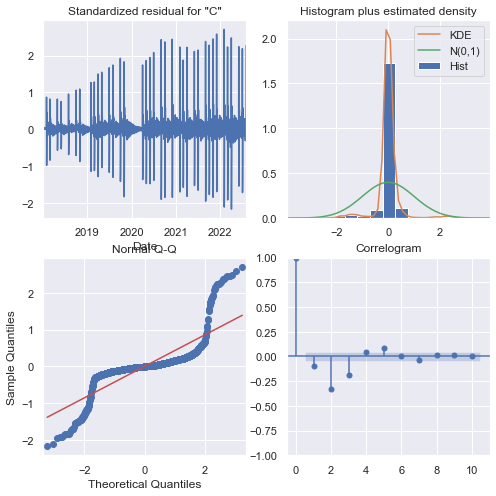

In [119]:
# Call plot_diagnostics() on the results calculated above 
output_pg.plot_diagnostics(figsize=(8, 8))
plt.show()

In [120]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=False)
pred_conf = pred.conf_int()

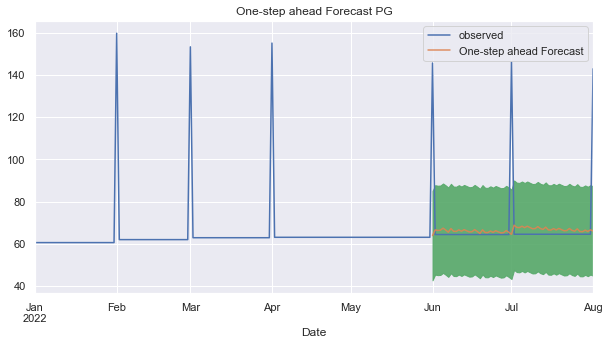

In [121]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = (10, 5)

# Plot observed values
ax = pg_new['2022':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.9)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.set_title('One-step ahead Forecast PG')
plt.legend()
plt.show()

In [122]:
pred.predicted_mean

Date
2022-06-01    63.868337
2022-06-02    66.573790
2022-06-03    66.315752
2022-06-04    66.426461
2022-06-05    67.389825
                ...    
2022-07-28    65.746031
2022-07-29    66.460516
2022-07-30    65.839891
2022-07-31    66.591471
2022-08-01    66.047126
Freq: D, Name: predicted_mean, Length: 62, dtype: float64

In [123]:
# Get the real and predicted values
PG_forecasted = pred.predicted_mean
PG_truth = pg_new['2022-06-01':]

# Compute the mean square error
mse = ((PG_forecasted - PG_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 315.37


The mean squared error for PG is the highest of the three stocks within analyis. We will see if PG exhibits a lower mse for Linear Regression. 

In [124]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

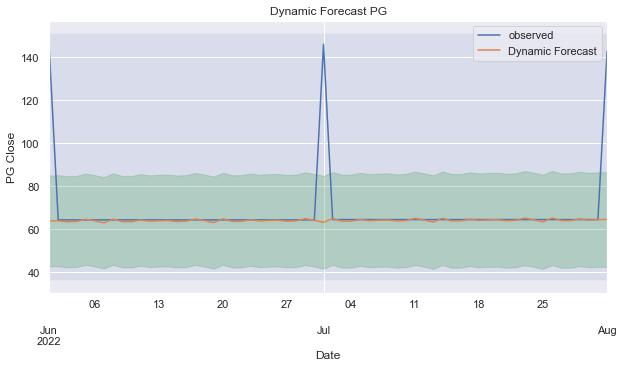

In [125]:
# Plot the dynamic forecast with confidence intervals.

ax = pg_new['2022-06-01':].plot(label='observed', figsize=(10, 5))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-06-01'), PG_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('PG Close')
ax.set_title('Dynamic Forecast PG')
plt.legend()
plt.show()

After analysis we have determined that PG shows a slight downward trend. 

### Linear Regression WMT 

We will create a new dataset for linear regression below.

In [127]:
# create new dataframe for linear regression
WMT_lr = WMT

In [128]:
WMT_lr = WMT_lr.drop('Symbol', axis=1)

First model created below. Without log transforming any of the features, we still see a high r-squared. 

In [129]:
# Model displays a very high R-squared which is promising
b_wmt = 'Close~Gold+Ether+USD+PPI+SPClose'

model_wmt = ols(formula=b_wmt, data=WMT_lr).fit()
model_wmt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     76.73
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           7.33e-17
Time:                        14:14:35   Log-Likelihood:                -120.55
No. Observations:                  38   AIC:                             253.1
Df Residuals:                      32   BIC:                             262.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.0015     35.281     -0.369      0.715     -84.867      58.864
Gold           0.0547      0.008      6.550      0.000       0.038       0.072
Ether         -0.0031      0.002     -1.544      0.132      -0.007       0.001
USD            0.1726      0.343      0.503      0.619      -0.527       0.872
PPI           -0.1718      0.052     -3.289      0.002      -0.278      -0.065
SPClose        0.0190      0.005      3.485      0.001       0.008       0.030
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.515
Skew:                           0.119   Prob(JB):                        0.773
Kurtosis:                       2.481   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


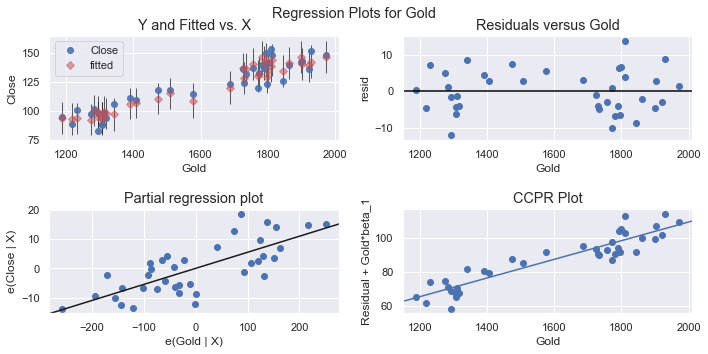

In [130]:
# Visualize terms, specifically Gold

fig = plt.figure(figsize=(10,5))
fig = sm.graphics.plot_regress_exog(model_wmt, "Gold", fig=fig)
plt.show()

We will begin log transforming Gold and the close price of WMT below. 

<AxesSubplot:>

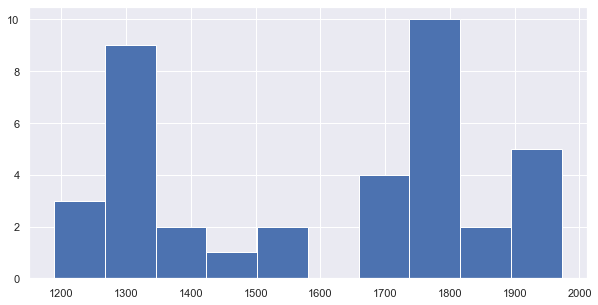

In [131]:
# Gold
WMT_lr['Gold'].hist()

<AxesSubplot:>

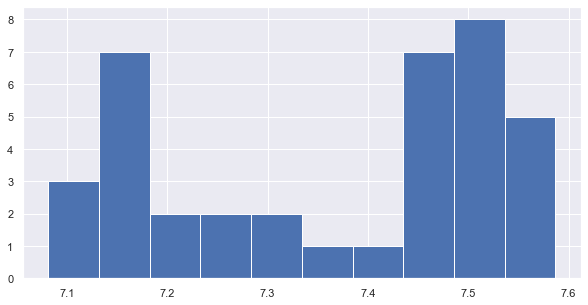

In [132]:
# in order to scale this distribution we will need to perform a log transform 
WMT_lr['log_Gold'] = np.log(WMT_lr['Gold'])
WMT_lr['log_Gold'].hist()

<AxesSubplot:>

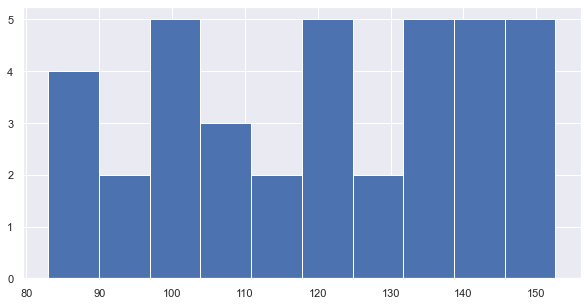

In [133]:
WMT['Close'].hist()

<AxesSubplot:>

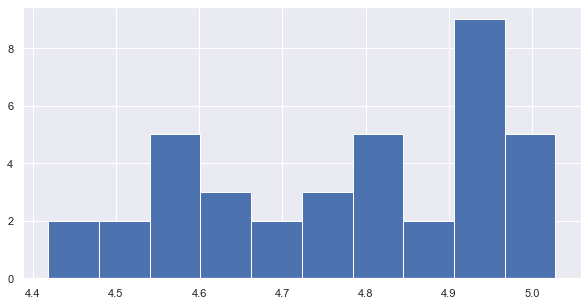

In [134]:
WMT_lr['log_Close'] = np.log(WMT_lr['Close'])
WMT_lr['log_Close'].hist()

The final model post log transformations, it shows a slightly lower r-squared but still is very high.

In [135]:
# final model

b2_wmt = 'log_Close~log_Gold+Ether+USD+PPI+SPClose'

model2_wmt = ols(formula=b2_wmt, data=WMT_lr).fit()
model2_wmt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Close   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     73.94
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.26e-16
Time:                        14:14:36   Log-Likelihood:                 59.517
No. Observations:                  38   AIC:                            -107.0
Df Residuals:                      32   BIC:                            -97.21
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0670      0.650     -1.642      0.110      -2.391       0.257
log_Gold       0.7166      0.113      6.331      0.000       0.486       0.947
Ether      -3.057e-05   1.74e-05     -1.754      0.089   -6.61e-05    4.94e-06
USD            0.0028      0.003      0.912      0.368      -0.003       0.009
PPI           -0.0015      0.000     -3.168      0.003      -0.002      -0.001
SPClose        0.0002   4.75e-05      3.553      0.001    7.21e-05       0.000
==============================================================================
Omnibus:                        0.350   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.335
Skew:                          -0.203   Prob(JB):                        0.846
Kurtosis:                       2.783   Cond. No.                     2.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The Q-Q plot below, for the second model, shows the normality of distribution. It also shows taht the model is linear. 

<ipython-input-136-06ae57e86191>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


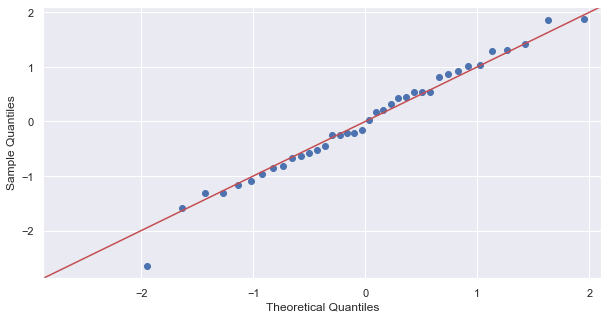

In [136]:
residuals_wmt = model2_wmt.resid
fig = sm.graphics.qqplot(residuals_wmt, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

<AxesSubplot:>

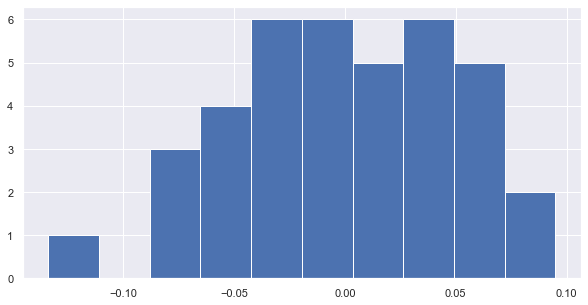

In [137]:
# This histogram shows the normal distribution
residuals_wmt.hist()

In [138]:
# Perform White's test 

white_test_wmt = het_white(model2_wmt.resid, model2_wmt.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test_wmt)))

# p-value is small which shows that the residuals are homoscedastic and therefore evenly distributed

{'Test Statistic': 17.454007239058875, 'Test Statistic p-value': 0.6233267123820959, 'F-Statistic': 0.7220827110094082, 'F-Test p-value': 0.7589067655725635}


In [139]:
residuals_wmt = model2_wmt.resid

In [140]:
X = WMT_lr.drop(['Close', 'log_Close'], axis=1)

y_pred = model_wmt.predict(X)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Residual Scatterplot')]

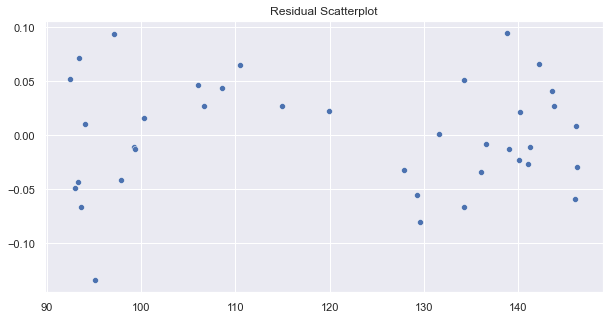

In [141]:
sns.scatterplot(y_pred,residuals_wmt).set(title='Residual Scatterplot')

Conduct mean squared error test to observe accuracy of Linear Regression for WMT. 

In [142]:
yr = WMT_lr['Gold']
Xr = WMT_lr.drop(columns=['Gold'], axis=1)

reg = LinearRegression().fit(Xr, yr)

mean_squared_error(yr, reg.predict(Xr))

99.7467529529283

Based on Linear Regression analysis, we can see that Linear Regression observed a much higher mean squared error than the SARIMA models. Therefore showing that the SARIMA model was a more accurate forecast.

### Linear Regression KO 

In [144]:
# create new dataframe for KO
ko_lr = KO

For linear regression we do not need "Symbol" or "Date" columns, therefore we will drop them. 

In [146]:
ko_lr = ko_lr.drop(["Symbol","Date"], axis=1)

Like WMT, the initial model for WMT shows a relatively high r-squared. This is promising, but we will continue with log transformations to see if we are able to raise the r-squared higher.  

In [147]:
# Model displays a very high R-squared 
b_ko = 'Close~Gold+Ether+USD+PPI+SPClose'

model_ko = ols(formula=b_ko, data=ko_lr).fit()
model_ko.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     35.56
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           3.66e-12
Time:                        14:14:36   Log-Likelihood:                -87.966
No. Observations:                  38   AIC:                             187.9
Df Residuals:                      32   BIC:                             197.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8597     14.969     -0.391      0.698     -36.350      24.631
Gold          -0.0078      0.004     -2.195      0.036      -0.015      -0.001
Ether         -0.0019      0.001     -2.211      0.034      -0.004      -0.000
USD            0.1491      0.146      1.024      0.313      -0.147       0.446
PPI            0.1141      0.022      5.150      0.000       0.069       0.159
SPClose        0.0091      0.002      3.949      0.000       0.004       0.014
==============================================================================
Omnibus:                        1.350   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                0.934
Skew:                           0.384   Prob(JB):                        0.627
Kurtosis:                       2.973   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


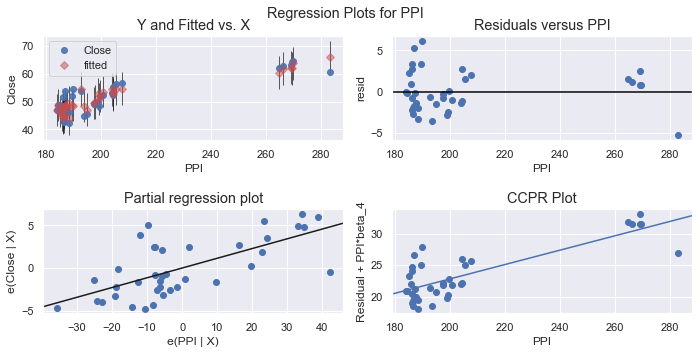

In [178]:
# Visualize terms, specifically PPI

fig = plt.figure(figsize=(10,5))
fig = sm.graphics.plot_regress_exog(model_ko, "PPI", fig=fig)
plt.show()

<AxesSubplot:>

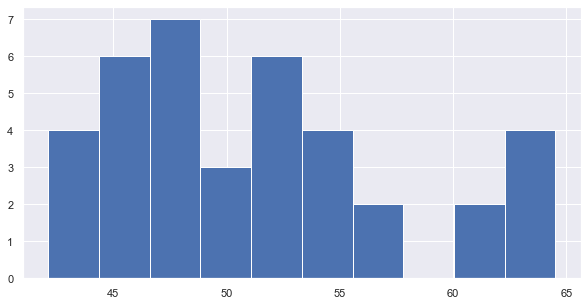

In [149]:
ko_lr['Close'].hist()

<AxesSubplot:>

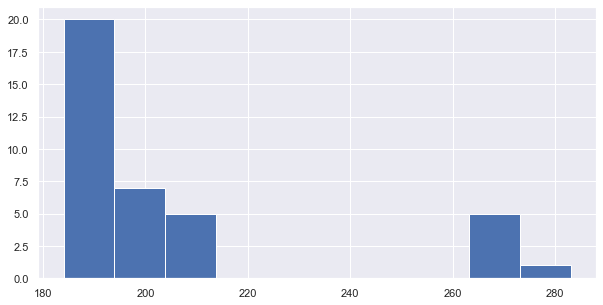

In [150]:
ko_lr['PPI'].hist()

<AxesSubplot:>

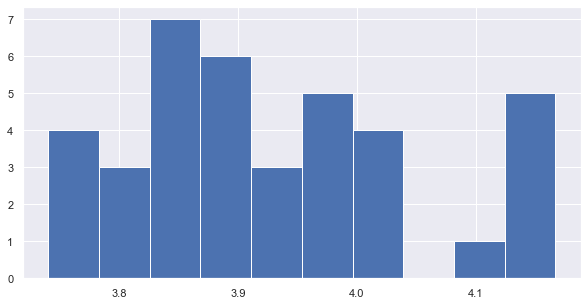

In [151]:
ko_lr['log_Close'] = np.log(ko_lr['Close'])
ko_lr['log_Close'].hist()

<AxesSubplot:>

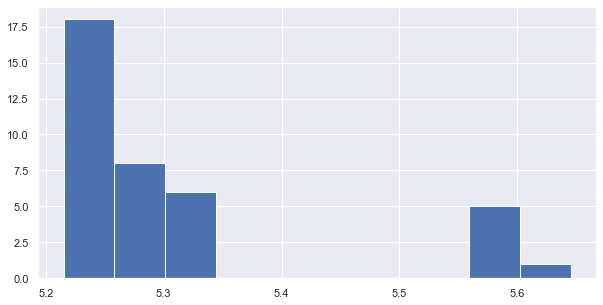

In [152]:
ko_lr['log_PPI'] = np.log(ko_lr['PPI'])
ko_lr['log_PPI'].hist()

Like WMT the r-squared was lowered after log transformations, regardless it is still a high r-squared and still applicable to our analysis. 

In [153]:
# final model

b2_ko = 'log_Close~Gold+Ether+USD+log_PPI+SPClose'

model2_ko = ols(formula=b2_ko, data=ko_lr).fit()
model2_ko.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Close   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     32.07
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.44e-11
Time:                        14:14:37   Log-Likelihood:                 61.071
No. Observations:                  38   AIC:                            -110.1
Df Residuals:                      32   BIC:                            -100.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9004      0.462      1.949      0.060      -0.041       1.841
Gold          -0.0002   6.99e-05     -2.317      0.027      -0.000   -1.96e-05
Ether      -4.099e-05   1.68e-05     -2.443      0.020   -7.52e-05   -6.82e-06
USD            0.0027      0.003      0.945      0.352      -0.003       0.009
log_PPI        0.4454      0.103      4.340      0.000       0.236       0.654
SPClose        0.0002   4.58e-05      4.180      0.000    9.82e-05       0.000
==============================================================================
Omnibus:                        1.841   Durbin-Watson:                   1.323
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.455
Skew:                           0.476   Prob(JB):                        0.483
Kurtosis:                       2.884   Cond. No.                     2.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The Q-Q plot shows that KO close price and PPI are linear with one another. Further proving the high r-squared. 

<ipython-input-154-d0364ca56a34>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


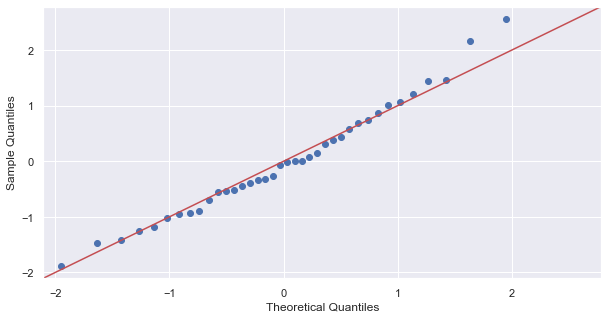

In [154]:
residuals_ko = model2_ko.resid
fig = sm.graphics.qqplot(residuals_ko, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

<AxesSubplot:>

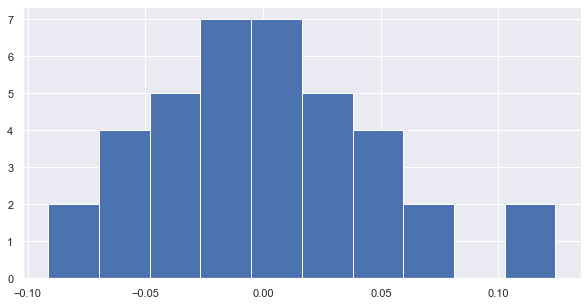

In [155]:
# This histogram shows the normal distribution

residuals_ko.hist()

In [156]:
# Perform White's test 

white_test_ko = het_white(model2_ko.resid, model2_ko.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test_ko)))

{'Test Statistic': 23.545451639264005, 'Test Statistic p-value': 0.26281150074206155, 'F-Statistic': 1.384590745687979, 'F-Test p-value': 0.25112046426969586}


In [157]:
residuals_ko = model2_ko.resid

In [158]:
X_ko = ko_lr.drop(['Close', 'log_Close'], axis=1)

y_pred_ko = model_ko.predict(X_ko)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Residual Scatterplot')]

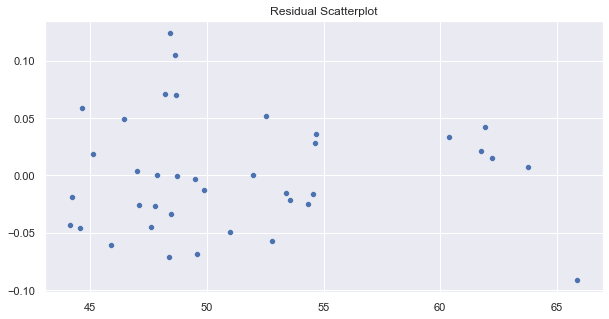

In [159]:
sns.scatterplot(y_pred_ko,residuals_ko).set(title='Residual Scatterplot')

In [160]:
yrk = ko_lr['PPI']
Xrk = ko_lr.drop(columns=['PPI'], axis=1)

In [161]:
regk = LinearRegression().fit(Xr, yrk)

In [162]:
mean_squared_error(yrk, regk.predict(Xrk))

8867.583322191393

The mean squared error is very high for Linear Regression of KO. We will use the SARIMA model for our recommendations. 

### Linear Regression PG

Like the last two linear regression models, we will begin analysis by creating a new data frame for PG for linear regression. 

In [164]:
pg_lr = PG

We will drop the Symbol and Date columns since these columns are irrelevant for linear regression analysis. 

In [165]:
pg_lr = pg_lr.drop(['Symbol','Date'], axis=1)

The first linear regression model shows that PG almost has a perfect r-squared relationship with the features of the dataset. We will still try to raise the r-squared by performing log transformations. 

In [166]:
# Model displays a very high R-squared 
b_pg = 'Close~Gold+Ether+USD+PPI+SPClose'

model_pg = ols(formula=b_pg, data=pg_lr).fit()
model_pg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     76.17
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           8.17e-17
Time:                        14:14:38   Log-Likelihood:                -127.42
No. Observations:                  38   AIC:                             266.8
Df Residuals:                      32   BIC:                             276.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -191.3496     42.274     -4.526      0.000    -277.459    -105.240
Gold           0.0316      0.010      3.158      0.003       0.011       0.052
Ether         -0.0049      0.002     -2.035      0.050      -0.010     5.3e-06
USD            1.4253      0.411      3.465      0.002       0.588       2.263
PPI            0.0158      0.063      0.253      0.802      -0.112       0.143
SPClose        0.0288      0.007      4.417      0.000       0.016       0.042
==============================================================================
Omnibus:                        1.517   Durbin-Watson:                   0.580
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.049
Skew:                          -0.052   Prob(JB):                        0.592
Kurtosis:                       2.193   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


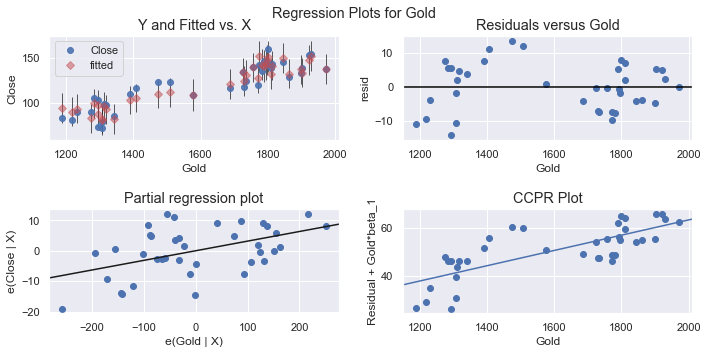

In [167]:
# Visualize terms, specifically Gold

fig = plt.figure(figsize=(10,5))
fig = sm.graphics.plot_regress_exog(model_pg, "Gold", fig=fig)
plt.show()

<AxesSubplot:>

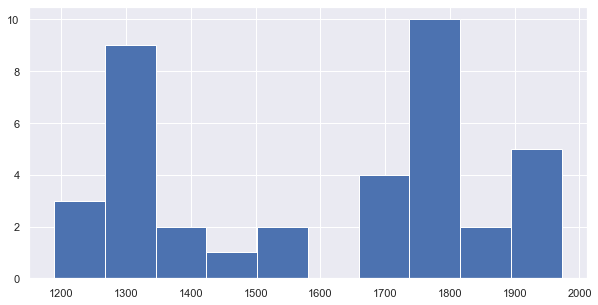

In [168]:
# Gold
pg_lr['Gold'].hist()

<AxesSubplot:>

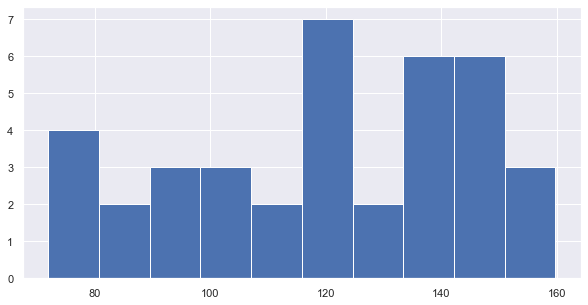

In [169]:
pg_lr['Close'].hist()

<AxesSubplot:>

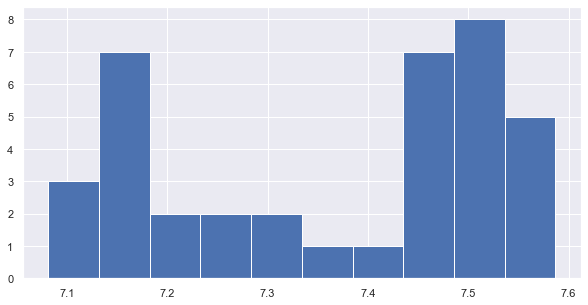

In [170]:
# in order to scale this distribution we will need to perform a log transform 

pg_lr['log_Gold'] = np.log(pg_lr['Gold'])
pg_lr['log_Gold'].hist()

Unlike the last two linear regression models, log transformations did raise the r-squared for the PG. We will use this model for linear regression. 

In [171]:
# final model

b2_pg = 'Close~log_Gold+Ether+USD+PPI+SPClose'

model2_pg = ols(formula=b2_pg, data=pg_lr).fit()
model2_pg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     78.62
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           5.13e-17
Time:                        14:14:39   Log-Likelihood:                -126.86
No. Observations:                  38   AIC:                             265.7
Df Residuals:                      32   BIC:                             275.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -508.2905     87.705     -5.795      0.000    -686.939    -329.642
log_Gold      51.1521     15.273      3.349      0.002      20.042      82.262
Ether         -0.0048      0.002     -2.058      0.048      -0.010   -4.99e-05
USD            1.3498      0.412      3.276      0.003       0.511       2.189
PPI            0.0227      0.062      0.366      0.717      -0.104       0.149
SPClose        0.0282      0.006      4.400      0.000       0.015       0.041
==============================================================================
Omnibus:                        1.909   Durbin-Watson:                   0.588
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.187
Skew:                          -0.072   Prob(JB):                        0.552
Kurtosis:                       2.146   Cond. No.                     2.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
# Perform White's test 

white_test_pg = het_white(model2_pg.resid, model2_pg.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test_ko)))

{'Test Statistic': 23.545451639264005, 'Test Statistic p-value': 0.26281150074206155, 'F-Statistic': 1.384590745687979, 'F-Test p-value': 0.25112046426969586}


PG is nearly completely linear with Gold, as shown below with the Q-Q plot.

<ipython-input-173-0a9be62e1fe1>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


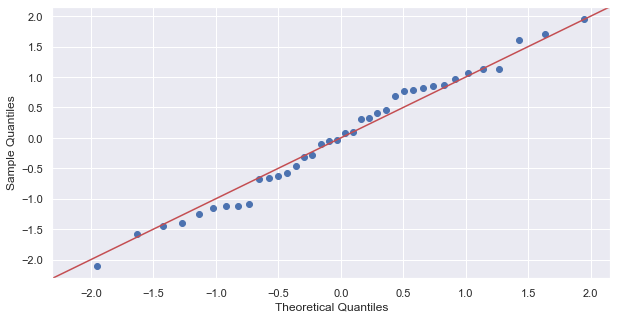

In [173]:
residuals_pg = model2_pg.resid
fig = sm.graphics.qqplot(residuals_pg, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

<AxesSubplot:>

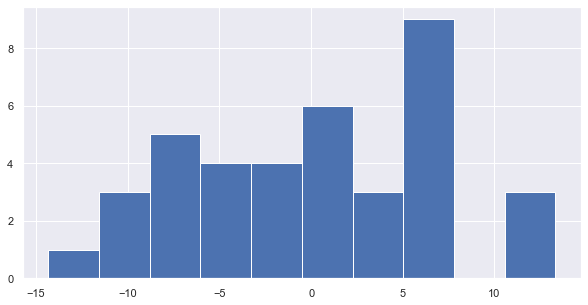

In [174]:
residuals_pg.hist()

In [175]:
X_pg = pg_lr.drop(['Close'], axis=1)

y_pred_pg = model_pg.predict(X_pg)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Residual Scatterplot')]

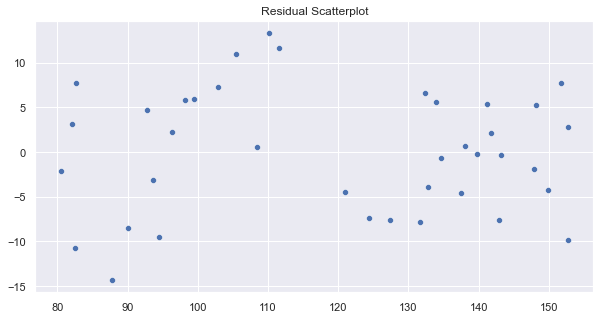

In [176]:
sns.scatterplot(y_pred_pg,residuals_pg).set(title='Residual Scatterplot')

In [177]:
yrp = pg_lr['Gold']
Xrp = pg_lr.drop(columns=['Gold'], axis=1)

regp = LinearRegression().fit(Xrp, yrp)

mean_squared_error(yrp, regp.predict(Xrp))

119.5088022156065

## Conclusions

After analysis of the top three defensive stocks, determined by market cap, there were patterns that were observed. The main pattern observed was that defensive stocks did provide protection against market volatility. Based on these observations the recommendations go as follows: 

<br /> 1) Walmart showed to have an downward trend, hold or sell WMT. 

<br /> 2) KO showed to have an upward trend, buy KO.  

<br /> 3) PG showed a upward trend, buy PG.

## Next Steps 

1) This project focused mainly on recent market data, beginning in 2017. This created issues when trying to identify an accurate trend. For more accurate results we will gather information about the markets at an earlier date, starting preferably at 2010. 

2) We will include other indices such as the VIX, NASDAQ, and Dow Jones to provide a wider market perspective to see how defensive stocks hedge against moves in the broader market. 